# Tests

This Jupyter notebook shows some tests for extracting and evaluating the constant-Q transform spectral envelope coefficients (CQT-SEC) (mostly personal).

Contents:
1. [Preliminary Tests](#1)
    1. [Create a note scale and compute its CQT spectrogram](#1A)
    2. [Decompose the CQT spectrogram into a spectral envelope and a pitch component](#1B)
    3. [Extract the CQT-SECs from the envelope and compare them to the MFCCs](#1C)
2. [Test on a Small Dataset](#2)
    1. [Create a small dataset from the NSynth dataset](#2A)
    2. [Compute the CQT-SECs and the MFCCs](#2B)
    3. [Compare the note similarities](#2C)
    4. [Compare the instrument similarities](#2D)
    5. [Compare the instrument similarity scores for different versions of CQT-SEC](#2E)
    
Author:
- Zafar Rafii
- zafarrafii@gmail.com
- http://zafarrafii.com
- https://github.com/zafarrafii
- https://www.linkedin.com/in/zafarrafii/
- 08/18/21

## <a id="1"></a>1. Preliminary Tests ##

### <a id="1A"></a>A. Create a note scale and compute its CQT spectrogram

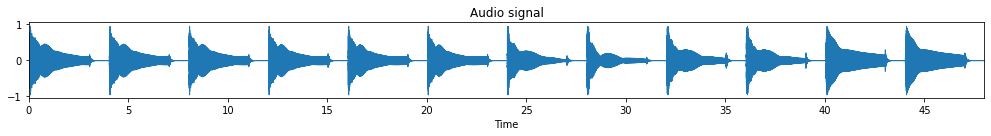

C:\Users\zarafii2001\Anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


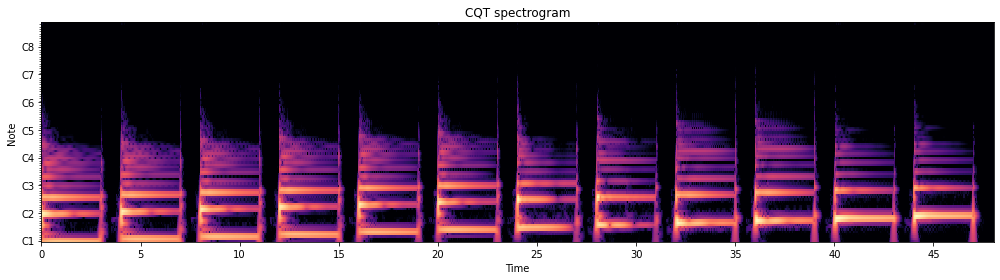

In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Define the parameters for the notes to concatenate
folder_path = r'nsynth\nsynth-train\audio'
instrument_names = ['bass_acoustic_000']
note_number = 24
note_numbers = np.arange(note_number, note_number+12)
velocity_number = 75
sampling_frequency = 16000

# Loop over the instrument names and note numbers to concatenate the notes
audio_signal = np.empty(0)
for instrument_name in instrument_names:
    for note_number in note_numbers:
    
        # Get the path to the file
        file_name = f'{instrument_name}-{note_number:03d}-{velocity_number:03d}.wav'
        file_path = os.path.join(folder_path, file_name)
        
        # Load the current audio signal and concatenate them
        audio_signal1, _ = librosa.load(file_path, sr=sampling_frequency, mono=True)
        audio_signal = np.concatenate((audio_signal, audio_signal1))
        
# Comptute the CQT spectrogram of the signal
step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
minimum_frequency = 32.70
maximum_frequency = sampling_frequency/2
octave_resolution = 12
number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
audio_cqt = librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, fmin=minimum_frequency, \
                        n_bins=number_frequencies, bins_per_octave=octave_resolution)
cqt_spectrogram = np.abs(audio_cqt)

# Display the audio signal and the CQT spectrogram
plt.figure(figsize=(14, 2))
librosa.display.waveplot(audio_signal, sr=sampling_frequency)
plt.title('Audio signal')
plt.tight_layout()
plt.show()
plt.figure(figsize=(14, 4))
librosa.display.specshow(librosa.amplitude_to_db(cqt_spectrogram, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, x_axis='time', y_axis='cqt_note', bins_per_octave=octave_resolution)
plt.title('CQT spectrogram')
plt.tight_layout()
plt.show()

### <a id="1B"></a>B. Decompose the CQT spectrogram into a spectral envelope and a pitch component

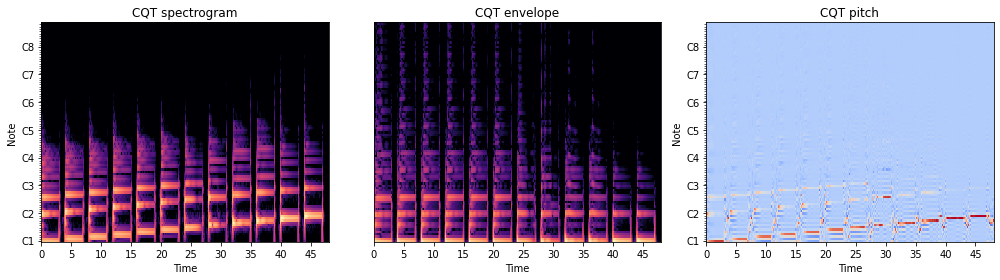

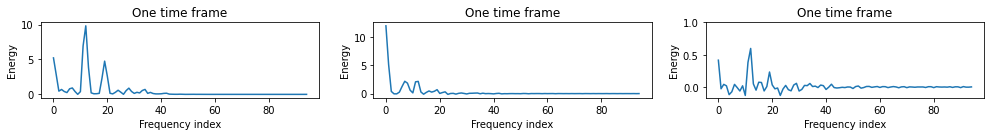

C:\Users\zarafii2001\Anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


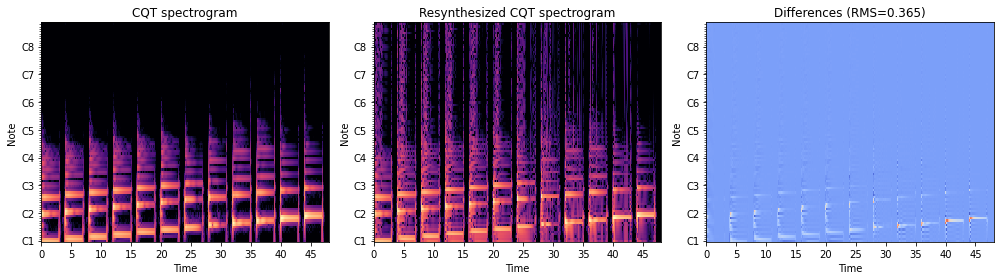

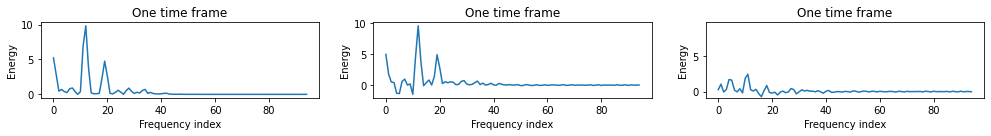

C:\Users\zarafii2001\Anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


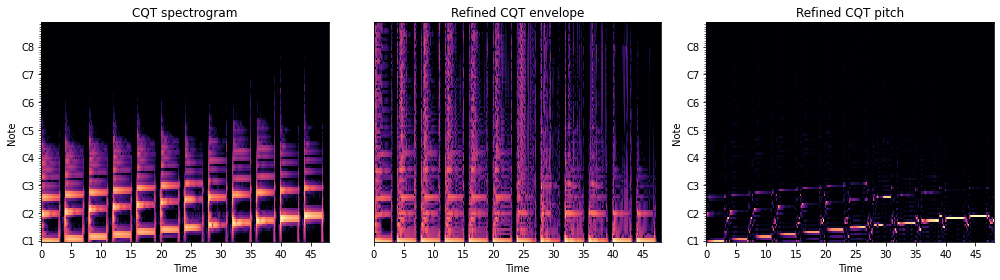

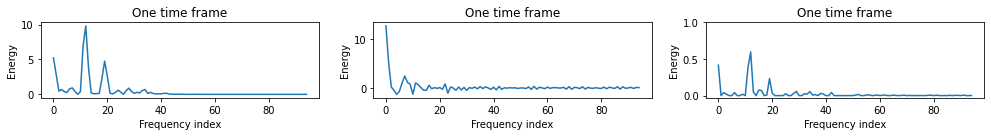

C:\Users\zarafii2001\Anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


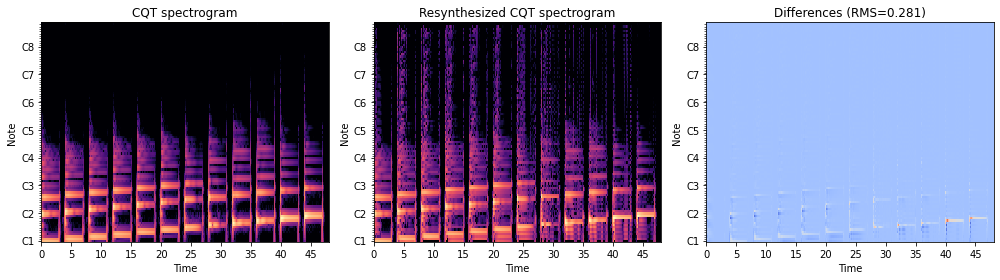

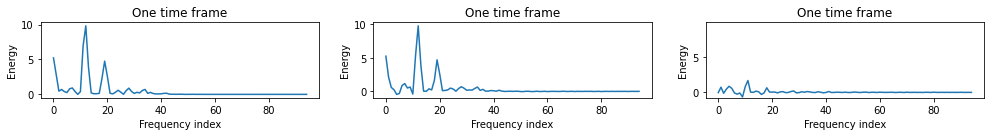

In [2]:
# Derive the CQT envelope and the CQT pitch
ftcqt_spectrogram = np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)
absftcqt_spectrogram = abs(ftcqt_spectrogram)
cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/absftcqt_spectrogram, axis=0)[0:number_frequencies, :])

# Resynthesize the CQT spectrogram by convolving the envelope and pitch
number_times = np.shape(cqt_spectrogram)[1]
cqt_spectrogram2 = np.zeros((number_frequencies, number_times))
for i in range(number_times):
    cqt_spectrogram2[:, i] = np.convolve(cqt_envelope[:, i], cqt_pitch[:, i])[0:number_frequencies]

# Display the CQT spectrogram, the envelope and pitch, the resynthesized CQT spectrogram, and the differences
j = 10
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
librosa.display.specshow(librosa.amplitude_to_db(cqt_spectrogram, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, \
                         x_axis='time', y_axis='cqt_note')
plt.title('CQT spectrogram')
plt.subplot(1, 3, 2)
librosa.display.specshow(librosa.amplitude_to_db(cqt_envelope, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, x_axis='time')
plt.title('CQT envelope')
plt.subplot(1, 3, 3)
librosa.display.specshow(cqt_pitch, sr=sampling_frequency, hop_length=step_length, fmin=minimum_frequency, \
                         bins_per_octave=octave_resolution, x_axis='time', y_axis='cqt_note')
plt.title('CQT pitch')
plt.tight_layout()
plt.show()
plt.figure(figsize=(14, 2))
plt.subplot(1, 3, 1), plt.plot(cqt_spectrogram[:, j])
plt.title('One time frame'), plt.xlabel('Frequency index'), plt.ylabel('Energy')
plt.subplot(1, 3, 2), plt.plot(cqt_envelope[:, j])
plt.title('One time frame'), plt.xlabel('Frequency index'), plt.ylabel('Energy')
plt.subplot(1, 3, 3), plt.plot(cqt_pitch[:, j]), plt.ylim(top=1)
plt.title('One time frame'), plt.xlabel('Frequency index'), plt.ylabel('Energy')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
librosa.display.specshow(librosa.amplitude_to_db(cqt_spectrogram, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, \
                         x_axis='time', y_axis='cqt_note')
plt.title('CQT spectrogram')
plt.subplot(1, 3, 2)
librosa.display.specshow(librosa.amplitude_to_db(cqt_spectrogram2, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, \
                         x_axis='time', y_axis='cqt_note')
plt.title('Resynthesized CQT spectrogram')
plt.subplot(1, 3, 3)
librosa.display.specshow(cqt_spectrogram-cqt_spectrogram2, sr=sampling_frequency, hop_length=step_length, \
                         fmin=minimum_frequency, bins_per_octave=octave_resolution, x_axis='time', y_axis='cqt_note')
rms_value = np.round(np.sqrt(np.mean(np.power(cqt_spectrogram-cqt_spectrogram2, 2))), 3)
plt.title(f'Differences (RMS={rms_value})')
plt.tight_layout()
plt.show()
plt.figure(figsize=(14, 2))
plt.subplot(1, 3, 1), plt.plot(cqt_spectrogram[:, j])
plt.title('One time frame'), plt.xlabel('Frequency index'), plt.ylabel('Energy')
plt.subplot(1, 3, 2), plt.plot(cqt_spectrogram2[:, j])
plt.title('One time frame'), plt.xlabel('Frequency index'), plt.ylabel('Energy')
plt.subplot(1, 3, 3), plt.plot(cqt_spectrogram[:, j]-cqt_spectrogram2[:, j]), plt.ylim(top=max(cqt_spectrogram[:, j]))
plt.title('One time frame'), plt.xlabel('Frequency index'), plt.ylabel('Energy')
plt.tight_layout()
plt.show()

# Refine the pitch, and then the envelope
cqt_pitch2 = np.copy(cqt_pitch)
cqt_pitch2[cqt_pitch2 < 0] = 0
cqt_envelope2 = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch2, 2*number_frequencies-1, axis=0)+1e-7), \
                                    axis=0)[0:number_frequencies, :])

# Resynthesize the CQT spectrogram by convolving the refined envelope and pitch
cqt_spectrogram2 = np.zeros((number_frequencies, number_times))
for i in range(number_times):
    cqt_spectrogram2[:, i] = np.convolve(cqt_envelope2[:, i], cqt_pitch2[:, i])[0:number_frequencies]

# Display everything again with the refined versions
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
librosa.display.specshow(librosa.amplitude_to_db(cqt_spectrogram, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, \
                         x_axis='time', y_axis='cqt_note')
plt.title('CQT spectrogram')
plt.subplot(1, 3, 2)
librosa.display.specshow(librosa.amplitude_to_db(cqt_envelope2, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, x_axis='time')
plt.title('Refined CQT envelope')
plt.subplot(1, 3, 3)
librosa.display.specshow(cqt_pitch2, sr=sampling_frequency, hop_length=step_length, fmin=minimum_frequency, \
                         bins_per_octave=octave_resolution, x_axis='time', y_axis='cqt_note')
plt.title('Refined CQT pitch')
plt.tight_layout()
plt.show()
plt.figure(figsize=(14, 2))
plt.subplot(1, 3, 1), plt.plot(cqt_spectrogram[:, j])
plt.title('One time frame'), plt.xlabel('Frequency index'), plt.ylabel('Energy')
plt.subplot(1, 3, 2), plt.plot(cqt_envelope2[:, j])
plt.title('One time frame'), plt.xlabel('Frequency index'), plt.ylabel('Energy')
plt.subplot(1, 3, 3), plt.plot(cqt_pitch2[:, j]), plt.ylim(top=1)
plt.title('One time frame'), plt.xlabel('Frequency index'), plt.ylabel('Energy')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
librosa.display.specshow(librosa.amplitude_to_db(cqt_spectrogram, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, \
                         x_axis='time', y_axis='cqt_note')
plt.title('CQT spectrogram')
plt.subplot(1, 3, 2)
librosa.display.specshow(librosa.amplitude_to_db(cqt_spectrogram2, ref=np.max), sr=sampling_frequency, \
                         hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution, \
                         x_axis='time', y_axis='cqt_note')
plt.title('Resynthesized CQT spectrogram')
plt.subplot(1, 3, 3)
librosa.display.specshow(cqt_spectrogram-cqt_spectrogram2, sr=sampling_frequency, hop_length=step_length, \
                         fmin=minimum_frequency, bins_per_octave=octave_resolution, x_axis='time', y_axis='cqt_note')
rms_value = np.round(np.sqrt(np.mean(np.power(cqt_spectrogram-cqt_spectrogram2, 2))), 3)
plt.title(f'Differences (RMS={rms_value})')
plt.tight_layout()
plt.show()
plt.figure(figsize=(14, 2))
plt.subplot(1, 3, 1), plt.plot(cqt_spectrogram[:, j])
plt.title('One time frame'), plt.xlabel('Frequency index'), plt.ylabel('Energy')
plt.subplot(1, 3, 2), plt.plot(cqt_spectrogram2[:, j])
plt.title('One time frame'), plt.xlabel('Frequency index'), plt.ylabel('Energy')
plt.subplot(1, 3, 3), plt.plot(cqt_spectrogram[:, j]-cqt_spectrogram2[:, j]), plt.ylim(top=max(cqt_spectrogram[:, j]))
plt.title('One time frame'), plt.xlabel('Frequency index'), plt.ylabel('Energy')
plt.tight_layout()
plt.show()

# # Resynthesize the signal
# audio_signal2 = librosa.icqt(cqt_spectrogram2*audio_cqt/cqt_spectrogram, sr=sampling_frequency, \
#                              hop_length=step_length, fmin=minimum_frequency, bins_per_octave=octave_resolution)
# audio_signal2 = np.max(abs(audio_signal))*audio_signal2/np.max(abs(audio_signal2))
# audio_signal2 = np.pad(audio_signal2, (0, len(audio_signal)-len(audio_signal2)), 'constant', constant_values=0)

### <a id="1C"></a>C. Extract the CQT-SECs from the envelope and compare them to the MFCCs

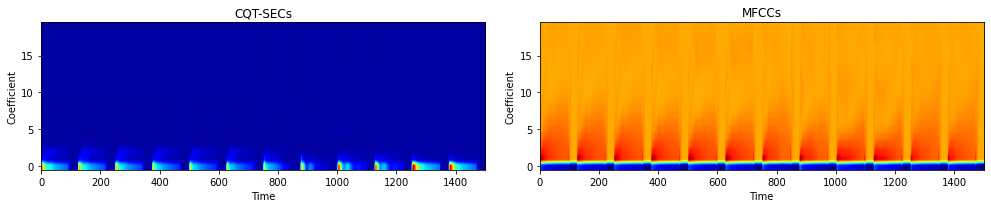

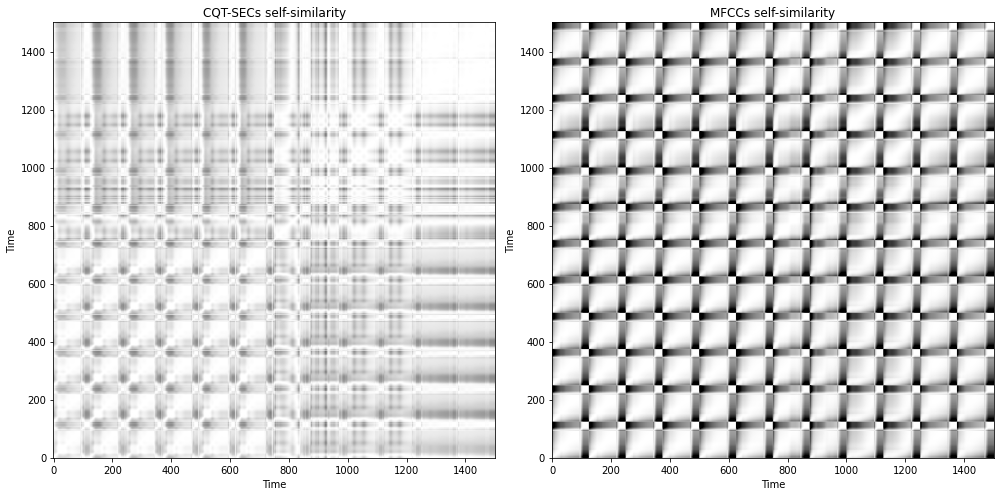

In [3]:
# Extract the CQT-SECs from the envelope
number_coefficients = 20
coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
cqt_sec = cqt_envelope[coefficient_indices, :]

# Compute the MFCCs using librosa
window_length = pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))
step_length = int(window_length/2)
audio_mfcc = librosa.feature.mfcc(y=audio_signal, sr=sampling_frequency, n_fft=window_length, hop_length=step_length)

# Compute the self-similarity matrices for the CQT-SECs and the MFCCs
normalized_feature = cqt_sec/(np.sqrt(np.sum(np.power(cqt_sec, 2), axis=0))+1e-16)
similarity_matrix1 = np.matmul(normalized_feature.T, normalized_feature)
normalized_feature = audio_mfcc/(np.sqrt(np.sum(np.power(audio_mfcc, 2), axis=0))+1e-16)
similarity_matrix2 = np.matmul(normalized_feature.T, normalized_feature)

# Plot the features and their self-similarity matrices
plt.figure(figsize=(14, 3))
plt.subplot(1, 2, 1), plt.imshow(cqt_sec, aspect='auto', cmap='jet', origin='lower')
plt.title('CQT-SECs'), plt.xlabel('Time'), plt.ylabel('Coefficient')
plt.subplot(1, 2, 2), plt.imshow(audio_mfcc, cmap='jet', aspect='auto', origin='lower')
plt.title('MFCCs'), plt.xlabel('Time'), plt.ylabel('Coefficient')
plt.tight_layout()
plt.show()
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1), plt.imshow(similarity_matrix1, cmap='gray', aspect='auto', origin='lower', vmin=0.9, vmax=1)
plt.title('CQT-SECs self-similarity'), plt.xlabel('Time'), plt.ylabel('Time')
plt.subplot(1, 2, 2), plt.imshow(similarity_matrix2, cmap='gray', aspect='auto', origin='lower', vmin=0.9, vmax=1)
plt.title('MFCCs self-similarity'), plt.xlabel('Time'), plt.ylabel('Time')
plt.tight_layout()
plt.show()

## <a id="2"></a>2. Test on a Small Dataset

### <a id="2A"></a>A. Create a small dataset from the NSynth dataset

In [4]:
import os
from shutil import copyfile

# The NSynth dataset can be downloaded from: https://magenta.tensorflow.org/datasets/nsynth

# Define the folders
folder_path = r'nsynth\nsynth-train\audio'
folder_path2 = r'nsynth11'

# Define the instrument names, numbers, and MIDIs
instrument_list = [{'name':'bass_acoustic', 'number': '000', 'midi': 24}, \
                   {'name':'brass_acoustic', 'number': '000', 'midi': 60}, \
                   {'name':'flute_acoustic', 'number': '000', 'midi': 60}, \
                   {'name':'guitar_acoustic', 'number': '000', 'midi': 60}, \
                   {'name':'keyboard_acoustic', 'number': '000', 'midi': 60}, \
                   {'name':'mallet_acoustic', 'number': '000', 'midi': 72}, \
                   {'name':'organ_electronic', 'number': '000', 'midi': 60}, \
                   {'name':'reed_acoustic', 'number': '000', 'midi': 60}, \
                   {'name':'string_acoustic', 'number': '000', 'midi': 60}, \
                   {'name':'synth_lead_synthetic', 'number': '000', 'midi': 60}, \
                   {'name':'vocal_acoustic', 'number': '002', 'midi': 60}]

# Loop over the list of notes to create the dataset
os.mkdir(folder_path2)
number_semitones = 12
for i in instrument_list:
    for j in range(i['midi'], i['midi']+number_semitones):
        file_name = f"{i['name']}_{i['number']}-{j:03d}-075.wav"
        file_path = os.path.join(folder_path, file_name)
        file_path2 = os.path.join(folder_path2, file_name)
        copyfile(file_path, file_path2)

### <a id="2B"></a>B. Compute the CQT-SECs and the MFCCs

In [ ]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt

# Define a function to compute the CQT-SECs
def cqtsec(audio_signal, sampling_frequency, number_coefficients=20):
    
    # Comptute the CQT spectrogram from the signal
    step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
    octave_resolution = 12
    minimum_frequency = 32.70
    maximum_frequency = sampling_frequency/2
    number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
    cqt_spectrogram = np.abs(librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, \
                                                  fmin=minimum_frequency, n_bins=number_frequencies, \
                                                  bins_per_octave=octave_resolution))
    
    # Compute the FT of the columns in the CQT spectrogram and their magnitude
    ftcqt_spectrogram = np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)
    absftcqt_spectrogram = abs(ftcqt_spectrogram)
    
    # Derive the CQT envelope and the CQT pitch
    cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/(absftcqt_spectrogram+1e-16), axis=0)[0:number_frequencies, :])
    
#     # Refine the CQT envelope
#     cqt_pitch[cqt_pitch<0] = 0
#     cqt_envelope = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch, 2*number_frequencies-1, axis=0)+1e-16), \
#                                        axis=0)[0:number_frequencies, :])
#     cqt_envelope[cqt_envelope<0] = 0
    
    # Get the indices of the CQT-SECs and extract them
    coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
    cqt_sec = cqt_envelope[coefficient_indices, :]

    return cqt_sec

# Define a function to compute the MFCCs
def mfcc(audio_signal, sampling_frequency, number_coefficients=20):
    
    # Compute the MFCCs using librosa's function
    window_length = pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))
    step_length = int(window_length/2)
    audio_mfcc = librosa.feature.mfcc(y=audio_signal, sr=sampling_frequency, n_mfcc=number_coefficients, 
                                      n_fft=window_length, hop_length=step_length)
    
    return audio_mfcc


# Get the path to the folder and its files
folder_path = r'nsynth11'
folder_listdir = os.listdir(folder_path)
number_files = len(folder_listdir)

# Create an empty list for storing dictionaries
audio_list = []

# Loop over the files
k = 0
for file_name in folder_listdir:
    k = k+1
    
    # Display the name of the file
    print(f'{k}/{number_files}: {file_name}')
    
    # Get the path to the audio file and load it
    file_path = os.path.join(folder_path, file_name)
    audio_signal, sampling_frequency = librosa.load(file_path, sr=None, mono=True)
    
    # Compute the CQT-SECs and the MFCCs
    cqt_sec = cqtsec(audio_signal, sampling_frequency)
    audio_mfcc = mfcc(audio_signal, sampling_frequency)
    
    # Create a dictionary for the current file and append it to the list
    audio_dict = {'name': file_name[0:-4], 'cqt-sec': cqt_sec, 'mfcc': audio_mfcc}
    audio_list.append(audio_dict)

### <a id="2C"></a>C. Compare the note similarities

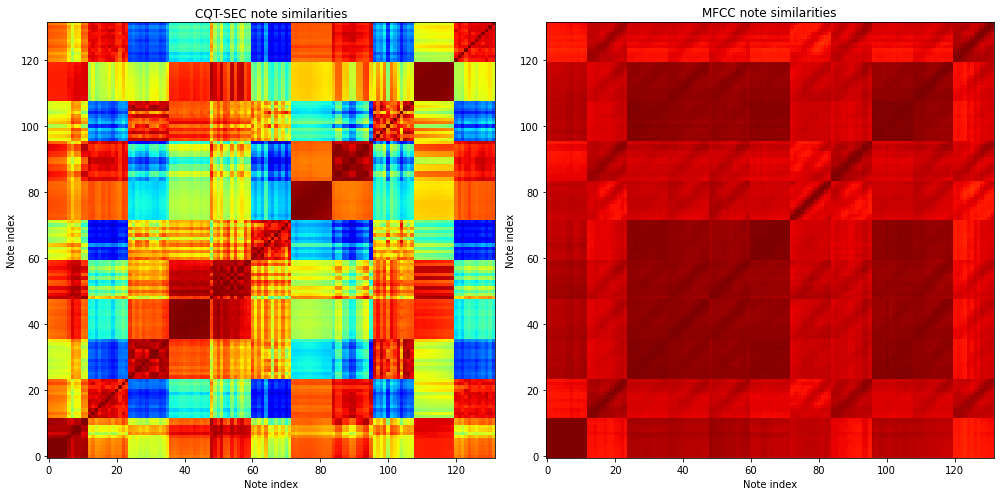

In [6]:
# Initialize the note similarity matrices for the CQT-SECs and the MFCCs
number_files = len(audio_list)
cqtsec_similarities = np.zeros((number_files, number_files))
mfcc_similarities = np.zeros((number_files, number_files))

# Loop over the rows of the matrices
for i in range(number_files):
    
    # Get the CQT-SECs and MFCCs for the current audio and normalize them
    cqt_sec0 = audio_list[i]['cqt-sec']
    cqt_sec0 = cqt_sec0/(np.sqrt(np.sum(np.power(cqt_sec0, 2), axis=None))+1e-16)
    audio_mfcc0 = audio_list[i]['mfcc']
    audio_mfcc0 = audio_mfcc0/(np.sqrt(np.sum(np.power(audio_mfcc0, 2), axis=None))+1e-16)
    
    # Loop over the columns of the matrices
    for j in range(number_files):
        
        # Get the CQT-SECs and MFCCs for the current audio and normalize them
        cqt_sec1 = audio_list[j]['cqt-sec']
        cqt_sec1 = cqt_sec1/(np.sqrt(np.sum(np.power(cqt_sec1, 2), axis=None))+1e-16)
        audio_mfcc1 = audio_list[j]['mfcc']
        audio_mfcc1 = audio_mfcc1/(np.sqrt(np.sum(np.power(audio_mfcc1, 2), axis=None))+1e-16)
        
        # Compute the note similarity between the CQT-SECs and between the MFCCs
        cqtsec_similarities[i, j] = np.sum(cqt_sec0*cqt_sec1, axis=None)
        mfcc_similarities[i, j] = np.sum(audio_mfcc0*audio_mfcc1, axis=None)
        
# Display the note similarity matrices for the CQT-SECs and the MFCCs
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1), plt.imshow(cqtsec_similarities, cmap="jet", aspect="auto", vmin=0, vmax=1, origin="lower")
plt.title('CQT-SEC note similarities'), plt.xlabel('Note index'), plt.ylabel('Note index')
plt.subplot(1, 2, 2), plt.imshow(mfcc_similarities, cmap="jet", aspect="auto", vmin=0, vmax=1, origin="lower")
plt.title('MFCC note similarities'), plt.xlabel('Note index'), plt.ylabel('Note index')
plt.tight_layout()
plt.show()

### <a id="2D"></a>D. Compare the instrument similarities

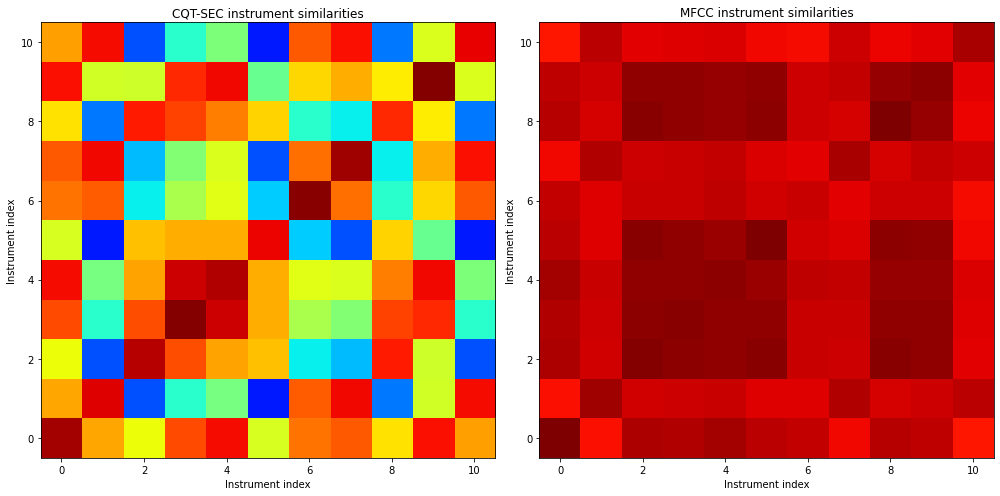

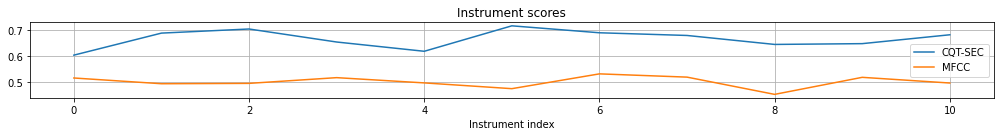

In [7]:
# Initialize the instrument similarity matrices and the final score vectors
number_instruments = 11
cqtsec_similarities2 = np.zeros((number_instruments, number_instruments))
mfcc_similarities2 = np.zeros((number_instruments, number_instruments))
cqtsec_scores2 = np.zeros(number_instruments)
mfcc_scores2 = np.zeros(number_instruments)

# Compute the similarity averaged over the instruments
for i in range(number_instruments):
    for j in range(number_instruments):
        cqtsec_similarities2[i, j] = np.mean(cqtsec_similarities[i*12:(i+1)*12, j*12:(j+1)*12])
        mfcc_similarities2[i, j] = np.mean(mfcc_similarities[i*12:(i+1)*12, j*12:(j+1)*12])

# Display the instrument similarity matrices
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1), plt.imshow(cqtsec_similarities2, cmap="jet", aspect="auto", vmin=0, vmax=1, origin="lower")
plt.title('CQT-SEC instrument similarities'), plt.xlabel('Instrument index'), plt.ylabel('Instrument index')
plt.subplot(1, 2, 2), plt.imshow(mfcc_similarities2, cmap="jet", aspect="auto", vmin=0, vmax=1, origin="lower")
plt.title('MFCC instrument similarities'), plt.xlabel('Instrument index'), plt.ylabel('Instrument index')
plt.tight_layout()
plt.show()

# Compute the final scores (mean between self-similarity and 1 minus the averaged cross-similarities)
for i in range(number_instruments):
    cqtsec_scores2[i] = (cqtsec_similarities2[i, i] \
    + 1-((np.sum(cqtsec_similarities2[i, :])-cqtsec_similarities2[i, i])/(number_instruments-1)))/2
    mfcc_scores2[i] = (cqtsec_similarities2[i, i] \
    + 1-((np.sum(mfcc_similarities2[i, :])-mfcc_similarities2[i, i])/(number_instruments-1)))/2

# Display the final scores
plt.figure(figsize=(14, 2))
plt.plot(cqtsec_scores2, label='CQT-SEC')
plt.plot(mfcc_scores2, label='MFCC')
plt.title('Instrument scores')
plt.xlabel('Instrument index')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

### <a id="2E"></a>E. Compare the instrument similarity scores for different versions of CQT-SEC

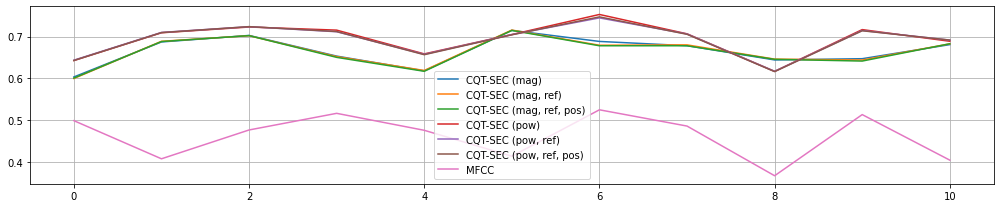

In [8]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt

# Get the path to the folder and the files
folder_path = r'nsynth11'
folder_listdir = os.listdir(folder_path)
number_files = len(folder_listdir)
number_instruments = 11

# Define a function to compute the CQT spectrogram
def cqtspectrogram(audio_signal, sampling_frequency):
    
    # Comptute the CQT spectrogram from the signal
    step_length = int(pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))/2)
    octave_resolution = 12
    minimum_frequency = 32.70
    maximum_frequency = sampling_frequency/2
    number_frequencies = round(octave_resolution * np.log2(maximum_frequency / minimum_frequency))
    cqt_spectrogram = np.abs(librosa.cqt(audio_signal, sr=sampling_frequency, hop_length=step_length, \
                                                  fmin=minimum_frequency, n_bins=number_frequencies, \
                                                  bins_per_octave=octave_resolution))
    
    return cqt_spectrogram

# Define a function to compute the MFCCs
def mfcc(audio_signal, sampling_frequency, n_mfcc=20):
    
    # Compute the MFCCs using librosa's function
    window_length = pow(2, int(np.ceil(np.log2(0.04*sampling_frequency))))
    step_length = int(window_length/2)
    audio_mfcc = librosa.feature.mfcc(y=audio_signal, sr=sampling_frequency, n_fft=window_length, hop_length=step_length)
    
    return audio_mfcc

# Loop over the files to store the CQT spectrograms and MFCCs
audio_list = []
k = 0
for file_name in folder_listdir:
    k = k+1
    
    # Get the path to the audio file and load it
    file_path = os.path.join(folder_path, file_name)
    audio_signal, sampling_frequency = librosa.load(file_path, sr=None, mono=True)
    
    # Compute the CQT spectrogram and the MFCCs
    cqt_spectrogram = cqtspectrogram(audio_signal, sampling_frequency)
    audio_mfcc = mfcc(audio_signal, sampling_frequency)
    
    # Create a dictionary for the current file and append it to the list
    audio_dict = {'name': file_name[0:-4], 'cqt': cqt_spectrogram, 'mfcc': audio_mfcc}
    audio_list.append(audio_dict)


plt.figure(figsize=(14, 3))

# Define a function to compute the CQT-SECs from the CQT spectrogram
def cqtsec(cqt_spectrogram, number_coefficients=20):
    
    # Compute the FT of the columns in the CQT spectrogram and their magnitude
    number_frequencies = np.shape(cqt_spectrogram)[0]
    ftcqt_spectrogram = np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)
    absftcqt_spectrogram = abs(ftcqt_spectrogram)
    
    # Derive the envelope and pitch
    cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/(absftcqt_spectrogram+1e-16), axis=0)[0:number_frequencies, :])
    
#     # Refine the envelope
#     cqt_pitch[cqt_pitch<0] = 0
#     cqt_envelope = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch, 2*number_frequencies-1, axis=0)+1e-16), \
#                                        axis=0)[0:number_frequencies, :])
#     cqt_envelope[cqt_envelope<0] = 0
    
    # Get the indices of the CQT-SECs and extract them
    octave_resolution = 12
    coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
    cqt_sec = cqt_envelope[coefficient_indices, :]

    return cqt_sec

# Loop over the files to extract the CQT-SECs
cqt_list = []
k = 0
for file_name in folder_listdir:
    
    # Get the CQT spectrogram and extract the CQT-SECs
    cqt_spectrogram = audio_list[k]['cqt']
    cqt_sec = cqtsec(cqt_spectrogram)
    
    # Create a dictionary for the current file and append it to the list
    cqt_dict = {'name': file_name[0:-4], 'cqt-sec': cqt_sec}
    cqt_list.append(cqt_dict)
    k = k+1

# Loop over the files twice to compute the cosine similarity matrix
cqtsec_matrix = np.zeros((number_files, number_files))
for i in range(number_files):
    
    # Get the CQT-SECs current audio and normalize them
    cqt_sec0 = cqt_list[i]['cqt-sec']
    cqt_sec0 = cqt_sec0/(np.sqrt(np.sum(np.power(cqt_sec0, 2), axis=None))+1e-16)
    
    for j in range(number_files):
        
        # Get the CQT-SECs for the current audio and normalize them
        cqt_sec1 = cqt_list[j]['cqt-sec']
        cqt_sec1 = cqt_sec1/(np.sqrt(np.sum(np.power(cqt_sec1, 2), axis=None))+1e-16)
        
        # Compute the cosine similarity between the CQT-SECs
        cqtsec_matrix[i, j] = np.sum(cqt_sec0*cqt_sec1, axis=None)
        
# Compute the similarity averaged over the instrument classes
cqtsec_matrix2 = np.zeros((number_instruments, number_instruments))
for i in range(number_instruments):
    for j in range(number_instruments):
        cqtsec_matrix2[i, j] = np.mean(cqtsec_matrix[i*12:(i+1)*12, j*12:(j+1)*12])

# Compute the final score vectors (mean between self-similarity and 1 minus the averaged cross-similarities)
cqtsec_vector2 = np.zeros(number_instruments)
for i in range(number_instruments):
    cqtsec_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(cqtsec_matrix2[i, :])-cqtsec_matrix2[i, i])/(number_instruments-1)))/2

# Display the final score vectors
plt.plot(cqtsec_vector2, label='CQT-SEC (mag)')


# Define a function to compute the CQT-SECs from the CQT spectrogram
def cqtsec(cqt_spectrogram, number_coefficients=20):
    
    # Compute the FT of the columns in the CQT spectrogram and their magnitude
    number_frequencies = np.shape(cqt_spectrogram)[0]
    ftcqt_spectrogram = np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)
    absftcqt_spectrogram = abs(ftcqt_spectrogram)
    
    # Derive the envelope and pitch
    cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/(absftcqt_spectrogram+1e-16), axis=0)[0:number_frequencies, :])
    
    # Refine the envelope
    cqt_pitch[cqt_pitch<0] = 0
    cqt_envelope = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch, 2*number_frequencies-1, axis=0)+1e-16), \
                                       axis=0)[0:number_frequencies, :])
#     cqt_envelope[cqt_envelope<0] = 0
    
    # Get the indices of the CQT-SECs and extract them
    octave_resolution = 12
    coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
    cqt_sec = cqt_envelope[coefficient_indices, :]

    return cqt_sec

# Loop over the files to extract the CQT-SECs
cqt_list = []
k = 0
for file_name in folder_listdir:
    
    # Get the CQT spectrogram and extract the CQT-SECs
    cqt_spectrogram = audio_list[k]['cqt']
    cqt_sec = cqtsec(cqt_spectrogram)
    
    # Create a dictionary for the current file and append it to the list
    cqt_dict = {'name': file_name[0:-4], 'cqt-sec': cqt_sec}
    cqt_list.append(cqt_dict)
    k = k+1
    
# Loop over the files twice to compute the cosine similarity matrix
cqtsec_matrix = np.zeros((number_files, number_files))
for i in range(number_files):
    
    # Get the CQT-SECs current audio and normalize them
    cqt_sec0 = cqt_list[i]['cqt-sec']
    cqt_sec0 = cqt_sec0/(np.sqrt(np.sum(np.power(cqt_sec0, 2), axis=None))+1e-16)
    
    for j in range(number_files):
        
        # Get the CQT-SECs for the current audio and normalize them
        cqt_sec1 = cqt_list[j]['cqt-sec']
        cqt_sec1 = cqt_sec1/(np.sqrt(np.sum(np.power(cqt_sec1, 2), axis=None))+1e-16)
        
        # Compute the cosine similarity between the CQT-SECs
        cqtsec_matrix[i, j] = np.sum(cqt_sec0*cqt_sec1, axis=None)
        
# Compute the similarity averaged over the instrument classes
cqtsec_matrix2 = np.zeros((number_instruments, number_instruments))
for i in range(number_instruments):
    for j in range(number_instruments):
        cqtsec_matrix2[i, j] = np.mean(cqtsec_matrix[i*12:(i+1)*12, j*12:(j+1)*12])

# Compute the final score vectors (mean between self-similarity and 1 minus the averaged cross-similarities)
cqtsec_vector2 = np.zeros(number_instruments)
for i in range(number_instruments):
    cqtsec_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(cqtsec_matrix2[i, :])-cqtsec_matrix2[i, i])/(number_instruments-1)))/2

# Display the final score vectors
plt.plot(cqtsec_vector2, label='CQT-SEC (mag, ref)')


# Define a function to compute the CQT-SECs from the CQT spectrogram
def cqtsec(cqt_spectrogram, number_coefficients=20):
    
    # Compute the FT of the columns in the CQT spectrogram and their magnitude
    number_frequencies = np.shape(cqt_spectrogram)[0]
    ftcqt_spectrogram = np.fft.fft(cqt_spectrogram, 2*number_frequencies-1, axis=0)
    absftcqt_spectrogram = abs(ftcqt_spectrogram)
    
    # Derive the envelope and pitch
    cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/(absftcqt_spectrogram+1e-16), axis=0)[0:number_frequencies, :])
    
    # Refine the envelope
    cqt_pitch[cqt_pitch<0] = 0
    cqt_envelope = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch, 2*number_frequencies-1, axis=0)+1e-16), \
                                       axis=0)[0:number_frequencies, :])
    cqt_envelope[cqt_envelope<0] = 0
    
    # Get the indices of the CQT-SECs and extract them
    octave_resolution = 12
    coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
    cqt_sec = cqt_envelope[coefficient_indices, :]

    return cqt_sec

# Loop over the files to extract the CQT-SECs
cqt_list = []
k = 0
for file_name in folder_listdir:
    
    # Get the CQT spectrogram and extract the CQT-SECs
    cqt_spectrogram = audio_list[k]['cqt']
    cqt_sec = cqtsec(cqt_spectrogram)
    
    # Create a dictionary for the current file and append it to the list
    cqt_dict = {'name': file_name[0:-4], 'cqt-sec': cqt_sec}
    cqt_list.append(cqt_dict)
    k = k+1
    
# Loop over the files twice to compute the cosine similarity matrix
cqtsec_matrix = np.zeros((number_files, number_files))
for i in range(number_files):
    
    # Get the CQT-SECs current audio and normalize them
    cqt_sec0 = cqt_list[i]['cqt-sec']
    cqt_sec0 = cqt_sec0/(np.sqrt(np.sum(np.power(cqt_sec0, 2), axis=None))+1e-16)
    
    for j in range(number_files):
        
        # Get the CQT-SECs for the current audio and normalize them
        cqt_sec1 = cqt_list[j]['cqt-sec']
        cqt_sec1 = cqt_sec1/(np.sqrt(np.sum(np.power(cqt_sec1, 2), axis=None))+1e-16)
        
        # Compute the cosine similarity between the CQT-SECs
        cqtsec_matrix[i, j] = np.sum(cqt_sec0*cqt_sec1, axis=None)
        
# Compute the similarity averaged over the instrument classes
cqtsec_matrix2 = np.zeros((number_instruments, number_instruments))
for i in range(number_instruments):
    for j in range(number_instruments):
        cqtsec_matrix2[i, j] = np.mean(cqtsec_matrix[i*12:(i+1)*12, j*12:(j+1)*12])

# Compute the final score vectors (mean between self-similarity and 1 minus the averaged cross-similarities)
cqtsec_vector2 = np.zeros(number_instruments)
for i in range(number_instruments):
    cqtsec_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(cqtsec_matrix2[i, :])-cqtsec_matrix2[i, i])/(number_instruments-1)))/2

# Display the final score vectors
plt.plot(cqtsec_vector2, label='CQT-SEC (mag, ref, pos)')


# Define a function to compute the CQT-SECs from the CQT spectrogram
def cqtsec(cqt_spectrogram, number_coefficients=20):
    
    # Compute the FT of the columns in the CQT spectrogram and their magnitude
    number_frequencies = np.shape(cqt_spectrogram)[0]
    ftcqt_spectrogram = np.fft.fft(np.power(cqt_spectrogram, 2), 2*number_frequencies-1, axis=0)
    absftcqt_spectrogram = abs(ftcqt_spectrogram)
    
    # Derive the envelope and pitch
    cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/(absftcqt_spectrogram+1e-16), axis=0)[0:number_frequencies, :])
    
#     # Refine the envelope
#     cqt_pitch[cqt_pitch<0] = 0
#     cqt_envelope = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch, 2*number_frequencies-1, axis=0)+1e-16), \
#                                        axis=0)[0:number_frequencies, :])
#     cqt_envelope[cqt_envelope<0] = 0
    
    # Get the indices of the CQT-SECs and extract them
    octave_resolution = 12
    coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
    cqt_sec = cqt_envelope[coefficient_indices, :]

    return cqt_sec

# Loop over the files to extract the CQT-SECs
cqt_list = []
k = 0
for file_name in folder_listdir:
    
    # Get the CQT spectrogram and extract the CQT-SECs
    cqt_spectrogram = audio_list[k]['cqt']
    cqt_sec = cqtsec(cqt_spectrogram)
    
    # Create a dictionary for the current file and append it to the list
    cqt_dict = {'name': file_name[0:-4], 'cqt-sec': cqt_sec}
    cqt_list.append(cqt_dict)
    k = k+1
    
# Loop over the files twice to compute the cosine similarity matrix
cqtsec_matrix = np.zeros((number_files, number_files))
for i in range(number_files):
    
    # Get the CQT-SECs current audio and normalize them
    cqt_sec0 = cqt_list[i]['cqt-sec']
    cqt_sec0 = cqt_sec0/(np.sqrt(np.sum(np.power(cqt_sec0, 2), axis=None))+1e-16)
    
    for j in range(number_files):
        
        # Get the CQT-SECs for the current audio and normalize them
        cqt_sec1 = cqt_list[j]['cqt-sec']
        cqt_sec1 = cqt_sec1/(np.sqrt(np.sum(np.power(cqt_sec1, 2), axis=None))+1e-16)
        
        # Compute the cosine similarity between the CQT-SECs
        cqtsec_matrix[i, j] = np.sum(cqt_sec0*cqt_sec1, axis=None)
        
# Compute the similarity averaged over the instrument classes
cqtsec_matrix2 = np.zeros((number_instruments, number_instruments))
for i in range(number_instruments):
    for j in range(number_instruments):
        cqtsec_matrix2[i, j] = np.mean(cqtsec_matrix[i*12:(i+1)*12, j*12:(j+1)*12])

# Compute the final score vectors (mean between self-similarity and 1 minus the averaged cross-similarities)
cqtsec_vector2 = np.zeros(number_instruments)
for i in range(number_instruments):
    cqtsec_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(cqtsec_matrix2[i, :])-cqtsec_matrix2[i, i])/(number_instruments-1)))/2

# Display the final score vectors
plt.plot(cqtsec_vector2, label='CQT-SEC (pow)')


# Define a function to compute the CQT-SECs from the CQT spectrogram
def cqtsec(cqt_spectrogram, number_coefficients=20):
    
    # Compute the FT of the columns in the CQT spectrogram and their magnitude
    number_frequencies = np.shape(cqt_spectrogram)[0]
    ftcqt_spectrogram = np.fft.fft(np.power(cqt_spectrogram, 2), 2*number_frequencies-1, axis=0)
    absftcqt_spectrogram = abs(ftcqt_spectrogram)
    
    # Derive the envelope and pitch
    cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/(absftcqt_spectrogram+1e-16), axis=0)[0:number_frequencies, :])
    
    # Refine the envelope
    cqt_pitch[cqt_pitch<0] = 0
    cqt_envelope = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch, 2*number_frequencies-1, axis=0)+1e-16), \
                                       axis=0)[0:number_frequencies, :])
#     cqt_envelope[cqt_envelope<0] = 0
    
    # Get the indices of the CQT-SECs and extract them
    octave_resolution = 12
    coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
    cqt_sec = cqt_envelope[coefficient_indices, :]

    return cqt_sec

# Loop over the files to extract the CQT-SECs
cqt_list = []
k = 0
for file_name in folder_listdir:
    
    # Get the CQT spectrogram and extract the CQT-SECs
    cqt_spectrogram = audio_list[k]['cqt']
    cqt_sec = cqtsec(cqt_spectrogram)
    
    # Create a dictionary for the current file and append it to the list
    cqt_dict = {'name': file_name[0:-4], 'cqt-sec': cqt_sec}
    cqt_list.append(cqt_dict)
    k = k+1
    
# Loop over the files twice to compute the cosine similarity matrix
cqtsec_matrix = np.zeros((number_files, number_files))
for i in range(number_files):
    
    # Get the CQT-SECs current audio and normalize them
    cqt_sec0 = cqt_list[i]['cqt-sec']
    cqt_sec0 = cqt_sec0/(np.sqrt(np.sum(np.power(cqt_sec0, 2), axis=None))+1e-16)
    
    for j in range(number_files):
        
        # Get the CQT-SECs for the current audio and normalize them
        cqt_sec1 = cqt_list[j]['cqt-sec']
        cqt_sec1 = cqt_sec1/(np.sqrt(np.sum(np.power(cqt_sec1, 2), axis=None))+1e-16)
        
        # Compute the cosine similarity between the CQT-SECs
        cqtsec_matrix[i, j] = np.sum(cqt_sec0*cqt_sec1, axis=None)
        
# Compute the similarity averaged over the instrument classes
cqtsec_matrix2 = np.zeros((number_instruments, number_instruments))
for i in range(number_instruments):
    for j in range(number_instruments):
        cqtsec_matrix2[i, j] = np.mean(cqtsec_matrix[i*12:(i+1)*12, j*12:(j+1)*12])

# Compute the final score vectors (mean between self-similarity and 1 minus the averaged cross-similarities)
cqtsec_vector2 = np.zeros(number_instruments)
for i in range(number_instruments):
    cqtsec_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(cqtsec_matrix2[i, :])-cqtsec_matrix2[i, i])/(number_instruments-1)))/2

# Display the final score vectors
plt.plot(cqtsec_vector2, label='CQT-SEC (pow, ref)')


# Define a function to compute the CQT-SECs from the CQT spectrogram
def cqtsec(cqt_spectrogram, number_coefficients=20):
    
    # Compute the FT of the columns in the CQT spectrogram and their magnitude
    number_frequencies = np.shape(cqt_spectrogram)[0]
    ftcqt_spectrogram = np.fft.fft(np.power(cqt_spectrogram, 2), 2*number_frequencies-1, axis=0)
    absftcqt_spectrogram = abs(ftcqt_spectrogram)
    
    # Derive the envelope and pitch
    cqt_envelope = np.real(np.fft.ifft(absftcqt_spectrogram, axis=0)[0:number_frequencies, :])
    cqt_pitch = np.real(np.fft.ifft(ftcqt_spectrogram/(absftcqt_spectrogram+1e-16), axis=0)[0:number_frequencies, :])
    
    # Refine the envelope
    cqt_pitch[cqt_pitch<0] = 0
    cqt_envelope = np.real(np.fft.ifft(ftcqt_spectrogram/(np.fft.fft(cqt_pitch, 2*number_frequencies-1, axis=0)+1e-16), \
                                       axis=0)[0:number_frequencies, :])
    cqt_envelope[cqt_envelope<0] = 0
    
    # Get the indices of the CQT-SECs and extract them
    octave_resolution = 12
    coefficient_indices = np.round(octave_resolution*np.log2(np.arange(1, number_coefficients+1))).astype(int)
    cqt_sec = cqt_envelope[coefficient_indices, :]

    return cqt_sec

# Loop over the files to extract the CQT-SECs
cqt_list = []
k = 0
for file_name in folder_listdir:
    
    # Get the CQT spectrogram and extract the CQT-SECs
    cqt_spectrogram = audio_list[k]['cqt']
    cqt_sec = cqtsec(cqt_spectrogram)
    
    # Create a dictionary for the current file and append it to the list
    cqt_dict = {'name': file_name[0:-4], 'cqt-sec': cqt_sec}
    cqt_list.append(cqt_dict)
    k = k+1
    
# Loop over the files twice to compute the cosine similarity matrix
cqtsec_matrix = np.zeros((number_files, number_files))
for i in range(number_files):
    
    # Get the CQT-SECs current audio and normalize them
    cqt_sec0 = cqt_list[i]['cqt-sec']
    cqt_sec0 = cqt_sec0/(np.sqrt(np.sum(np.power(cqt_sec0, 2), axis=None))+1e-16)
    
    for j in range(number_files):
        
        # Get the CQT-SECs for the current audio and normalize them
        cqt_sec1 = cqt_list[j]['cqt-sec']
        cqt_sec1 = cqt_sec1/(np.sqrt(np.sum(np.power(cqt_sec1, 2), axis=None))+1e-16)
        
        # Compute the cosine similarity between the CQT-SECs
        cqtsec_matrix[i, j] = np.sum(cqt_sec0*cqt_sec1, axis=None)
        
# Compute the similarity averaged over the instrument classes
cqtsec_matrix2 = np.zeros((number_instruments, number_instruments))
for i in range(number_instruments):
    for j in range(number_instruments):
        cqtsec_matrix2[i, j] = np.mean(cqtsec_matrix[i*12:(i+1)*12, j*12:(j+1)*12])

# Compute the final score vectors (mean between self-similarity and 1 minus the averaged cross-similarities)
cqtsec_vector2 = np.zeros(number_instruments)
for i in range(number_instruments):
    cqtsec_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(cqtsec_matrix2[i, :])-cqtsec_matrix2[i, i])/(number_instruments-1)))/2

# Display the final score vectors
plt.plot(cqtsec_vector2, label='CQT-SEC (pow, ref, pos)')

# Loop over the rows and columns of the matrix
mfcc_matrix = np.zeros((number_files, number_files))
for i in range(number_files):
    
    # Get the MFCCs for the current audio and normalize them
    audio_mfcc0 = audio_list[i]['mfcc']
    audio_mfcc0 = audio_mfcc0/(np.sqrt(np.sum(np.power(audio_mfcc0, 2), axis=None))+1e-16)
    
    for j in range(number_files):
        
        # Get the MFCCs for the current audio and normalize them
        audio_mfcc1 = audio_list[j]['mfcc']
        audio_mfcc1 = audio_mfcc1/(np.sqrt(np.sum(np.power(audio_mfcc1, 2), axis=None))+1e-16)
        
        # Compute the cosine similarity between the MFCCs
        mfcc_matrix[i, j] = np.sum(audio_mfcc0*audio_mfcc1, axis=None)
        
# Compute the similarity averaged over the instrument classes
mfcc_matrix2 = np.zeros((number_instruments, number_instruments))
for i in range(number_instruments):
    for j in range(number_instruments):
        mfcc_matrix2[i, j] = np.mean(mfcc_matrix[i*12:(i+1)*12, j*12:(j+1)*12])

# Compute the final score vectors (mean between self-similarity and 1 minus the averaged cross-similarities)
mfcc_vector2 = np.zeros(number_instruments)
for i in range(number_instruments):
    mfcc_vector2[i] = (cqtsec_matrix2[i, i] \
    + 1-((np.sum(mfcc_matrix2[i, :])-mfcc_matrix2[i, i])/(number_instruments-1)))/2

plt.plot(mfcc_vector2, label='MFCC')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()